# Simulating directional stellar arrangements with PhoSim on ComCam and WFS corner sensors 

**Summary**:  we simulate an arrow-like arrangement of stars that allows testing orientation of images as they are simulated with PhoSim, and passed through the ISR. We make the catalogs with `ts_phosim`  `SkySim()`, which uses the `ts_wep/policy/focalplanelayout.txt` to translate from input CCD x,y coordinates to ra,dec. Internally, it uses `lsst.sims.coordUtils.CameraUtils.raDecFromPixelCoords` to do the transformation. 

**Results**: To recover the desired orientation we need to use the transpose and `origin='lower'` setting in matplotlib.pyplot.imshow().

**Data**: For ComCam, the in/out of focus  postISR images are stored in `/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_arrow/singleArrow/input/rerun/run1/postISRCCD/` . Raw images are in `singleArrow/iter0/img/`. 

For LsstCam (corner WFS) the images are in `/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars/` and `input/rerun/run1/postISRCCD/` or `singleArrow/iter0/img/` for postISR /raw, respectively. 

## WFS simulate arrow of stars

[1500 1500 1500 1500] [1900 2200 2500 2800]
[ 400  700 1000 1300] [3000 3000 3000 3000]
y=1.00x 1500.00
[ 200  400  600  800 1000 1200 1400] [1700. 1900. 2100. 2300. 2500. 2700. 2900.]
[   0 1500 1500 1500 1500  400  700 1000 1300  200  400  600  800 1000
 1200 1400 1500] [   0. 1900. 2200. 2500. 2800. 3000. 3000. 3000. 3000. 1700. 1900. 2100.
 2300. 2500. 2700. 2900. 3000.]


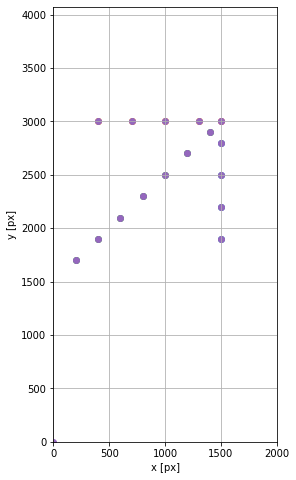

In [66]:
import os
import numpy as np 
from lsst.ts.wep.Utility import FilterType, CamType

from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.Utility import getConfigDir, getPhoSimPath, \
    getAoclcOutputPath
    
phosimDir = getPhoSimPath()

# Survey information
obsId = 9006000
filterType = FilterType.REF
ra = 0
decl = 0
rotSkyPos = 0


# Set the Telescope facade class
tele = TeleFacade()
tele.setPhoSimDir(phosimDir)
tele.setSurveyParam(obsId=obsId, filterType=filterType,
                    boresight=(ra, decl), rotAngInDeg=rotSkyPos)
tele.setInstName(CamType.LsstCam)

# Write the accumulated DOF file
#tele.writeAccDofFile(outputDir)

# Declare the SkySim()
skySim = SkySim()

# Set the observation information
mjd = tele.getCamMjd()
skySim.setObservationMetaData(ra, decl, rotSkyPos, mjd)

import matplotlib.pyplot as plt
%matplotlib inline



# each WFS half-chip is 2000x4072 px
def pixel_arrow(x_vertex=1500, y_vertex=3000, width=1100, 
                spacing=300, diag_spacing=200, xmin=0, xmax=2000,
                ymin=0, ymax=4072 , xy_offset = 1300 
               ):
    #x_vertex, y_vertex = 1500,3000  
    # width = 1100; spacing = 300
    xPx = np.array(0)
    yPx = np.array(0)
    # vertical part
    ys = np.arange(y_vertex-width,y_vertex, spacing )
    xs = x_vertex*np.ones_like(ys)
    print(xs,ys)
    xPx = np.append(xPx, xs)
    yPx = np.append(yPx, ys)


    # horizontal part 
    xh = np.arange(x_vertex-width,x_vertex, spacing)
    yh = y_vertex*np.ones_like(xh)
    print(xh, yh)
    xPx = np.append(xPx, xh)
    yPx = np.append(yPx, yh)


    # diagonal part:
    x_start, y_start = x_vertex-xy_offset, y_vertex-xy_offset

    a = (y_start-y_vertex)/(x_start-x_vertex)
    b = y_vertex-a*x_vertex
    print('y=%.2fx %.2f'%(a,b))

    #diag_spacing = 200
    xd = np.arange(x_start, x_vertex,diag_spacing)
    yd = a*xd+b
    print(xd,yd)
    xPx = np.append(xPx, xd)
    yPx = np.append(yPx, yd)

    # append vertex too 
    xPx = np.append(xPx, x_vertex)
    yPx = np.append(yPx, y_vertex)

    # plot what I expect on  a single WFS half-chip 
    fig,ax = plt.subplots(1,1,figsize=((4./2000)*xmax,(8./4072)*ymax))
    ax.scatter(xs,ys)
    ax.scatter(xh,yh)
    ax.scatter(xd,yd)
    ax.scatter(x_vertex,y_vertex)
    #xmin,xmax = 0,2000
    #ymin,ymax = 0,4072
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')

    ax.scatter(xPx, yPx)
    print(xPx, yPx)
    return xPx, yPx 
    
# WFS:  
xPx, yPx = pixel_arrow(x_vertex=1500, y_vertex=3000, width=1100, 
                spacing=300, diag_spacing=200, xmin=0, xmax=2000,
                ymin=0, ymax=4072, xy_offset=1300  )




In [40]:
# Add the interested stars
sensorName = ["R44_S00_C0", "R00_S22_C1", "R44_S00_C1", "R00_S22_C0",
              "R04_S20_C1", "R40_S02_C0", "R04_S20_C0", "R40_S02_C1"]
starMag = 15
starId = 0
for sensor in sensorName:
    for ii in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[ii],
                                yPx[ii], starMag)
        starId += 1


In [42]:
# Export sky information
d1 = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/' 
d2 = 'results_wfs'
outputDir = os.path.join(d1,d2)
outputSkyFilePath = os.path.join(outputDir, "skyWfsArrow.txt")
skySim.exportSkyToFile(outputSkyFilePath)


In [119]:
# plot the stars in that file
from astropy.table import Table
d1 = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/' 
d2 = 'results_wfs'
outputDir = os.path.join(d1,d2)
outputSkyFilePath = os.path.join(outputDir, "skyWfsArrow.txt")
stars = Table.read(outputSkyFilePath, format='ascii')


(1, 1.4)

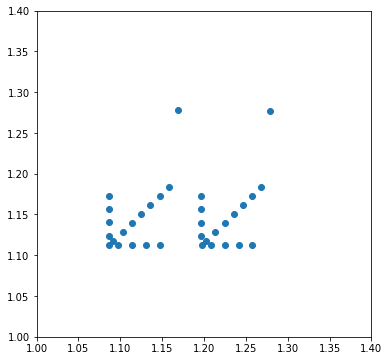

In [120]:
%matplotlib inline

m = stars['Ra']>180
stars['Ra'][m]  = stars['Ra'][m]-360
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(stars['Ra'],stars['Decl'])
ax.set_xlim(1,1.4)
ax.set_ylim(1,1.4)

## ComCam arrow 

[3500 3500 3500 3500 3500] [2000 2300 2600 2900 3200]
[2000 2300 2600 2900 3200] [3500 3500 3500 3500 3500]
y=1.00x 0.00
[1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400] [1000. 1200. 1400. 1600. 1800. 2000. 2200. 2400. 2600. 2800. 3000. 3200.
 3400.]
[   0 3500 3500 3500 3500 3500 2000 2300 2600 2900 3200 1000 1200 1400
 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3500] [   0. 2000. 2300. 2600. 2900. 3200. 3500. 3500. 3500. 3500. 3500. 1000.
 1200. 1400. 1600. 1800. 2000. 2200. 2400. 2600. 2800. 3000. 3200. 3400.
 3500.]


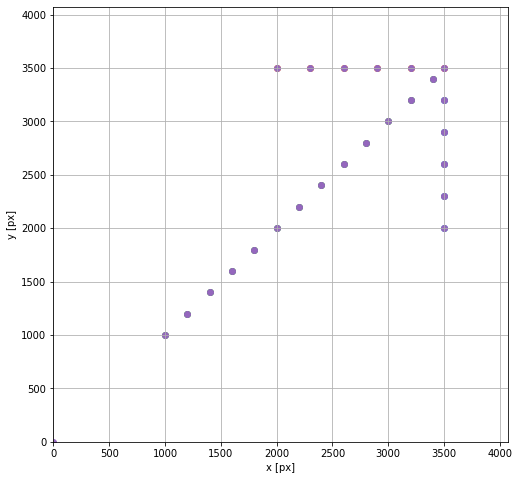

In [67]:
xPx, yPx = pixel_arrow(x_vertex=3500, y_vertex=3500, width=1500, 
                spacing=300, diag_spacing=200, xmin=0, xmax=4072,
                ymin=0, ymax=4072, xy_offset=2500  )

In [68]:
phosimDir = getPhoSimPath()

# Survey information
obsId = 9006000
filterType = FilterType.REF
ra = 0
decl = 0
rotSkyPos = 0


# Set the Telescope facade class for ComCam
tele = TeleFacade()
tele.setPhoSimDir(phosimDir)
tele.setSurveyParam(obsId=obsId, filterType=filterType,
                    boresight=(ra, decl), rotAngInDeg=rotSkyPos)
tele.setInstName(CamType.ComCam)

# Write the accumulated DOF file
#tele.writeAccDofFile(outputDir)

# Declare the SkySim()
skySim = SkySim()

# Set the observation information
mjd = tele.getCamMjd()
skySim.setObservationMetaData(ra, decl, rotSkyPos, mjd)

import matplotlib.pyplot as plt
%matplotlib inline

# Add the interested stars
sensorName = ["R22_S00", "R22_S01", "R22_S02", 
              "R22_S10", "R22_S11", "R22_S12", 
              "R22_S20", "R22_S21", "R22_S22"]
starMag = 15
starId = 0
for sensor in sensorName:
    for ii in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[ii],
                                yPx[ii], starMag)
        starId += 1


# Export sky information
d1 = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
d2 = 'results_arrow'
outputDir = os.path.join(d1,d2)
outputSkyFilePath = os.path.join(outputDir, "skyComCamArrow.txt")
skySim.exportSkyToFile(outputSkyFilePath)
       

/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/python/lsst/ts/phosim/telescope/TeleFacade.py:304: UserWarning: Use 'lsst' instead of 'comcam' in PhoSim.
  category=UserWarning)


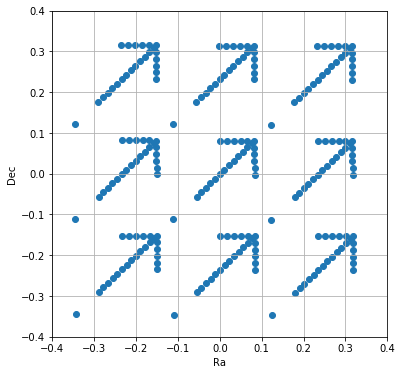

In [109]:
# plot the stars in that file
from astropy.table import Table
d1 = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
d2 = 'results_arrow'
outputDir = os.path.join(d1,d2)
outputSkyFilePath = os.path.join(outputDir, "skyComCamArrow.txt")
stars = Table.read(outputSkyFilePath, format='ascii')

%matplotlib inline

m = stars['Ra']>180
stars['Ra'][m]  = stars['Ra'][m]-360
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(stars['Ra'],stars['Decl'])
ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.4,0.4)
ax.set_xlabel('Ra')
ax.set_ylabel('Dec')
ax.grid()

So that is what we  would expect in the simulation ... 

# Show the WFS result:

In [110]:
import lsst.daf.persistence as dafPersist
import os 

# Read in the postISR image using the Butler 
dataDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_wfs/arrowStars/'

print('\nReading data from')
print(dataDir)
#print('For sensor %s '%sensor)
repo_dir = os.path.join(dataDir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)
print('Done')


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_wfs/arrowStars/
Done


In [111]:
focalType = 'intra'
expIdDic = {'intra':9006002, 'extra':9006002}
expId = expIdDic[focalType]
data_ids =[{'expId': expId , 'filter':'g', 'raftName':'R00',  'detectorName': 'S22', 'detector': 197},
           {'expId': expId , 'filter':'g', 'raftName':'R04',  'detectorName': 'S20', 'detector': 204},
           {'expId': expId , 'filter':'g', 'raftName':'R40',  'detectorName': 'S02', 'detector': 209},
           {'expId': expId , 'filter':'g', 'raftName':'R44',  'detectorName': 'S00', 'detector': 216}
          ]

# Read each figure as a postage stamp, store data to an array 
images = {}

for i in range(len(data_ids)):
    data_id = data_ids[i]
    sensor = data_id['raftName']+'_'+data_id['detectorName']
    print(sensor)
    post = butler.get('postISRCCD', **data_id) 

    # store in a dictionary
    images[sensor] = post.image.array

R00_S22
R04_S20
R40_S02
R44_S00


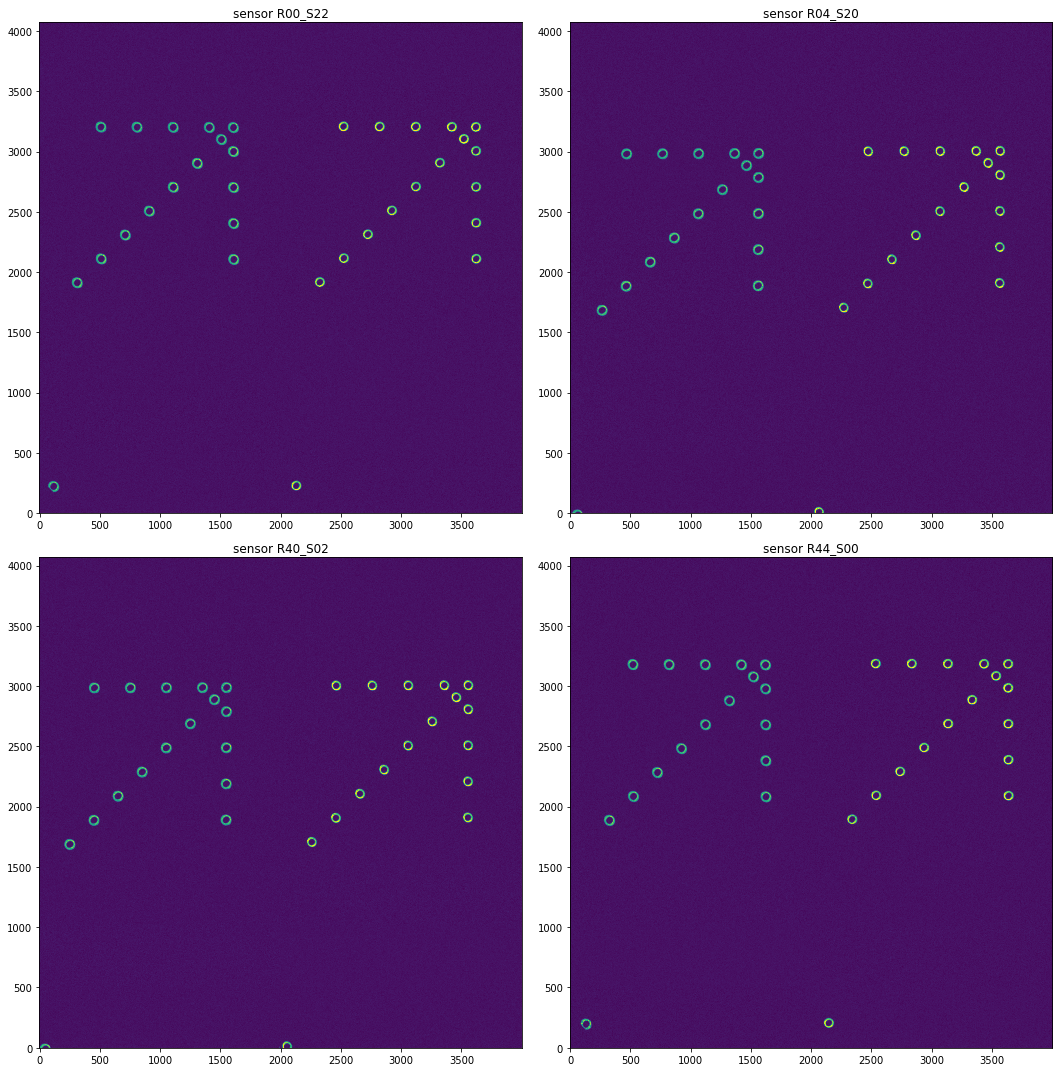

In [118]:
%matplotlib inline
focalType = 'intra'

fig, axs = plt.subplots(2,2,figsize=(15,15))
ax = np.ravel(axs)

i = 0 
for sensor in images.keys():
    img = ax[i].imshow(images[sensor].T, origin='lower', vmax=800)
    ax[i].set_title('sensor %s'%sensor)
    i += 1 

plt.tight_layout()


# Show the ComCam result 

In [97]:
import lsst.daf.persistence as dafPersist
import os 

# Read in the postISR image using the Butler 
dataDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_arrow/singleArrow/'

focalType = 'intra'  # choose whether extra or intra focal image
obsIdDic = {'intra':9006001,  'extra':9006002} 
obsId = obsIdDic[focalType]

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
print('\nReading data from')
print(dataDir)
repo_dir = os.path.join(dataDir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}

images = {}
for detector in detectors:
    sensor = raft+'_'+detector 
    print('For sensor %s '%sensor)
    detNum = detNumDict[detector]

    data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}
    post = butler.get('postISRCCD', **data_id) 
    image = post.image.array
    images[detector] = image

print('Done')



    


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_arrow/singleArrow/
For sensor R22_S00 
For sensor R22_S01 
For sensor R22_S02 
For sensor R22_S10 
For sensor R22_S11 
For sensor R22_S12 
For sensor R22_S20 
For sensor R22_S21 
For sensor R22_S22 
Done


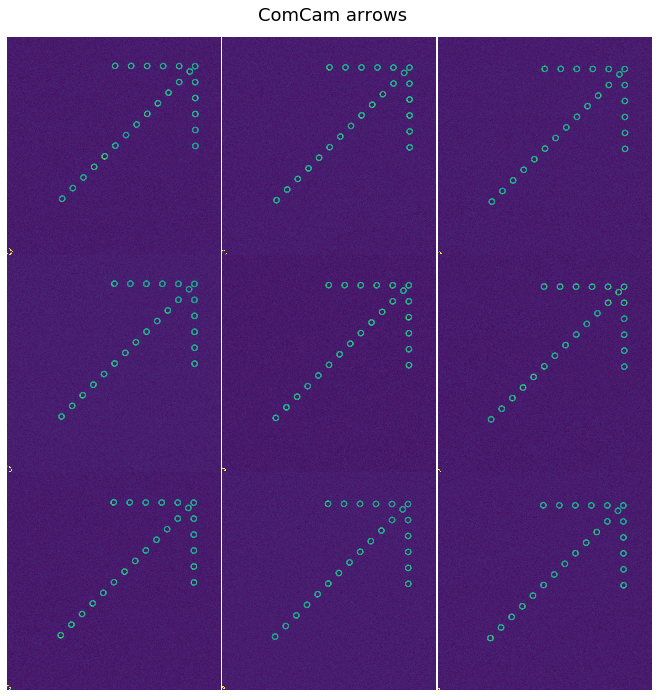

In [108]:
%matplotlib inline

fig,axs = plt.subplots(3,3,figsize=(12,12),frameon=False)
ax = np.ravel(axs)
detectors = list(images.keys())
for i in range(len(ax)):
    ax[i].imshow(images[detectors[i]].T, vmax=500, origin='lower')
    #ax[i].tick_params(axis='x',  which='both', bottom='off',  top='off', labelbottom='off')  
    #ax[i].xaxis.set_visible(False)
    #ax[i].yaxis.set_visible(False)
    ax[i].grid()
    ax[i].axis('off')
    
fig.subplots_adjust(hspace=0,wspace=-0.1)
fig.text(0.43,0.9,'ComCam arrows', fontsize=18)
plt.savefig('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks/comcam_arrows.png',
            bbox_inches='tight')